In [102]:
import requests
import bs4 as bs
import selenium as sel
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import pandas as pd
import tldextract as tld
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup
import csv
import os
from matplotlib import rcParams

In [103]:
rcParams['figure.figsize'] = 11.7,6

In [104]:
driver = webdriver.Chrome(ChromeDriverManager().install())

In [105]:
def get_sources(driver, video_link: str):
    driver.get(video_link)
    buttons = driver.find_elements('xpath',
                                "//button[contains(@class, 'box-border inline-flex flex-col items-center justify-center gap-1 rounded-full px-0 py-[.625rem] text-xs font-normal focus:outline-none focus-visible:ring-4 disabled:opacity-60 sm:text-sm xl:flex-row xl:gap-2')]")
    for button in buttons:
        if "Facts &amp; Sources" in button.get_attribute('innerHTML'):
            button.click()
    links = driver.find_elements('xpath',
                                "//a[contains(@class, 'box-border cursor-pointer items-center justify-center gap-2 rounded-full font-bold focus:outline-none focus-visible:ring-4 py-[.625rem] text-primary hover:opacity-80 focus-visible:ring-neutral-1/25 inline-flex px-0 text-sm')]") 
    links = [link.get_attribute('href') for link in links if link.get_attribute('href').split('.')[-1] != 'pdf']
    return links

In [106]:
def export_sources_csv_one_video(vid_link: str) -> None:
    title = vid_link.split('/')[-1].split('?')[0]
    directory = f"{vid_link.split('/')[-1].split('?')[-1].split('=')[-1]}-playlist"
    with open (f'{directory}/{title}.csv', 'w') as test_file:
        test_writer = csv.writer(test_file)
        test_writer.writerow(['video', 'subdomain', 'domain', 'top_level', 'response'])
        def parse_page(url):
            # perform the HTTP request to the specified URL
            try:
                response = requests.get(url).status_code
            except:
                response = '404'
            extracted = tld.extract(url)
            test_writer.writerow([title, extracted.subdomain, extracted.domain, extracted.suffix, response])
        
        urls = get_sources(driver, vid_link)
        
        # max number of threads to use
        MAX_THREADS = 12

        # initialize ThreadPoolExecutor and use it to call parse_page() in parallel
        with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
            executor.map(parse_page, urls)

In [107]:
def find_links_in_playlist(driver, playlist_link: str):
    driver.get(playlist_link)
    time.sleep(2)
    videos = driver.find_elements('xpath',
                                  "//a[contains(@class, 'grid grid-cols-[142px_1fr] items-center gap-4 overflow-hidden sm:grid-cols-[168px_1fr]')]")
    return videos

In [108]:
def get_sources_of_playlist(driver, play_list_link: 'str'):
    new_dir = f"{play_list_link.split('/')[-1].split('?')[-1].split('=')[-1]}-playlist"
    if new_dir not in os.listdir():
        os.mkdir(f"{play_list_link.split('/')[-1].split('?')[-1].split('=')[-1]}-playlist")
    videos = find_links_in_playlist(driver, play_list_link)

    fixed = []
    for video in videos:
        fixed.append(video.get_attribute('href'))

    for vid in tqdm(range(len(fixed))):
        vid = fixed[vid]
        export_sources_csv_one_video(vid)
    driver.close()

In [109]:
def get_data_frame_for_playlist(directory: str) -> pd.DataFrame:
    files = [_ for _ in os.listdir(directory) if _.endswith('.csv')]
    dfs = []
    for csv_file in files:
        df = pd.read_csv(os.path.join(directory, csv_file))
        dfs.append(df)
    final_df = pd.concat(dfs, ignore_index=True)
    return final_df

In [110]:
get_sources_of_playlist(driver,
                        'https://www.prageru.com/video/does-free-speech-offend-you?playlist=does-free-speech-offend-you')

100%|██████████| 20/20 [02:41<00:00,  8.07s/it]


In [99]:
def build_report(directory: str, subdomains: bool = True, domains: bool = True, top_levels: bool = True, responses: bool = True, graphs = True) -> None:
    df = get_data_frame_for_playlist(directory)
    display(f"{directory}")
    display(df.head())  
    display(df.describe())
    
    if subdomains:
        subs = df.subdomain.value_counts()
        display(subs[subs > 1])
        if graphs:
            sub_df = df[df.groupby('subdomain').subdomain.transform('count')>=2].copy() 
            my_plot = sns.countplot(x='subdomain', 
                                    data=sub_df, 
                                    order=sub_df['subdomain'].value_counts().index)
            my_plot.set_title(f"Subdomains for {' '.join(directory.split('-')[:-1])}")
            my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=80)
            my_plot
            plt.show()
            
    if domains:
        doms = df.domain.value_counts()
        display(doms[doms >= 6])
        if graphs:
            sub_df = df[df.groupby('domain').domain.transform('count')>=4].copy() 
            my_plot = sns.countplot(x='domain', 
                                    data=sub_df,
                                    order=sub_df['domain'].value_counts().index)
            my_plot.set_title(f"Domains for {' '.join(directory.split('-')[:-1])}")
            my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=80)
            my_plot
            plt.show()
    
    if top_levels:
        tops = df.top_level.value_counts()
        display(tops)
        if graphs:
            sub_df = df[df.groupby('top_level').top_level.transform('count')>=0].copy() 
            my_plot = sns.countplot(x='top_level', 
                                    data=sub_df,
                                    order=sub_df['top_level'].value_counts().index)
            my_plot.set_title(f"Top Level Domains for {' '.join(directory.split('-')[:-1])}")
            my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=80)
            my_plot
            plt.show()
    
    if responses:
        resps = df.response.value_counts()
        display(resps)
        if graphs:
            sub_df = df[df.groupby('response').response.transform('count')>=0].copy() 
            my_plot = sns.countplot(x='response',
                                    data=sub_df,
                                    order=sub_df['response'].value_counts().index)
            my_plot.set_title(f"Responses for {' '.join(directory.split('-')[:-1])}")
            my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=80)
            my_plot
            plt.show()
    
            

'what-science-reveals-about-climate-change-playlist'

,video,subdomain,domain,top_level,response
0,abundant-clean-and-safe,www,asirt,org,403
1,abundant-clean-and-safe,www,csmonitor,com,200
2,abundant-clean-and-safe,www,prageru,com,200
3,abundant-clean-and-safe,www,prageru,com,200
4,abundant-clean-and-safe,www,nei,org,403


,video,subdomain,domain,top_level,response
count,678,611,676,676,678
unique,29,37,190,17,8
top,why-you-should-love-fossil-fuel,www,amazon,com,200
freq,62,563,100,407,396


subdomain
www              563
web                6
econlog            4
onlinelibrary      2
nuclear            2
alexepstein        2
share              2
Name: count, dtype: int64

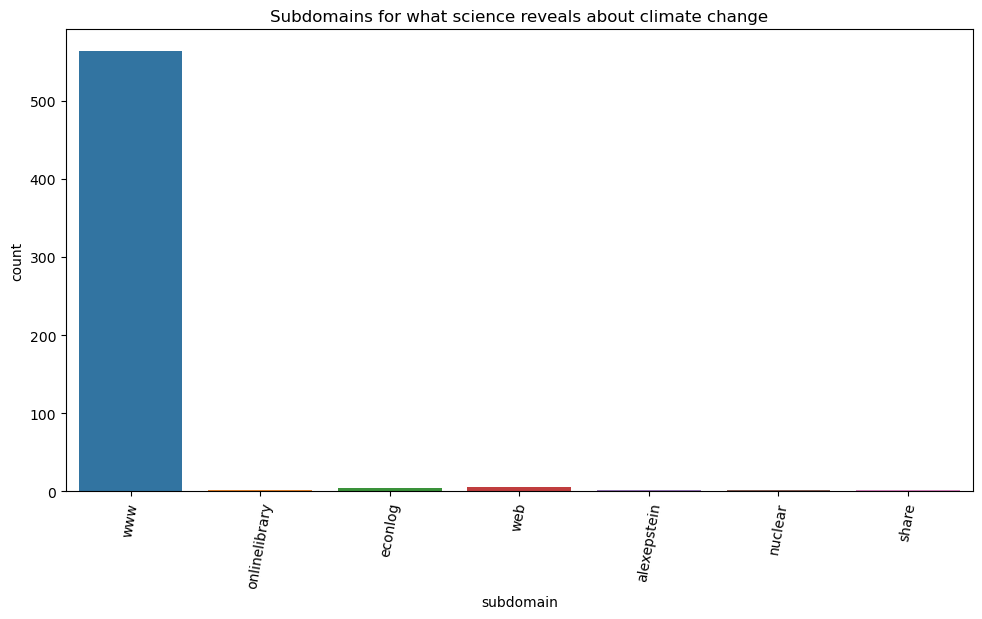

domain
amazon                     100
prageru                     56
wsj                         42
forbes                      42
nytimes                     19
econlib                     15
eia                         13
world-nuclear               13
ourworldindata              13
hoover                      11
youtube                     10
aei                         10
moralcaseforfossilfuels      8
latimes                      7
co2science                   7
economist                    7
thegwpf                      7
cato                         7
manhattan-institute          6
npr                          6
Name: count, dtype: int64

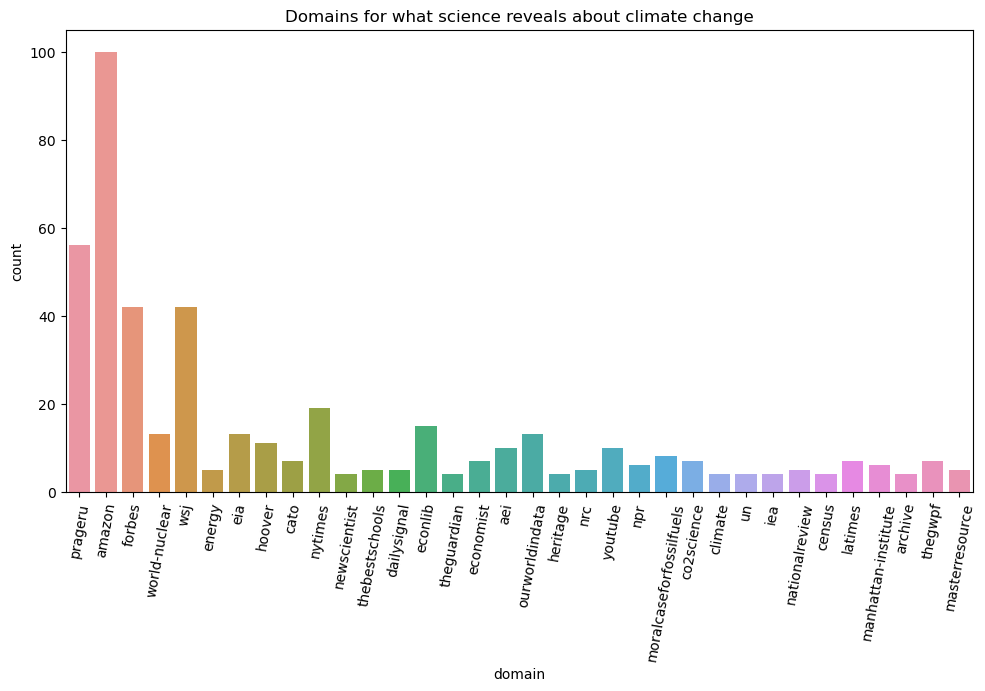

top_level
com          407
org          178
gov           58
edu           13
co.uk          4
int            3
net            3
gov.uk         1
es             1
ac.uk          1
eu             1
nl             1
edu.au         1
africa         1
institute      1
ie             1
ca             1
Name: count, dtype: int64

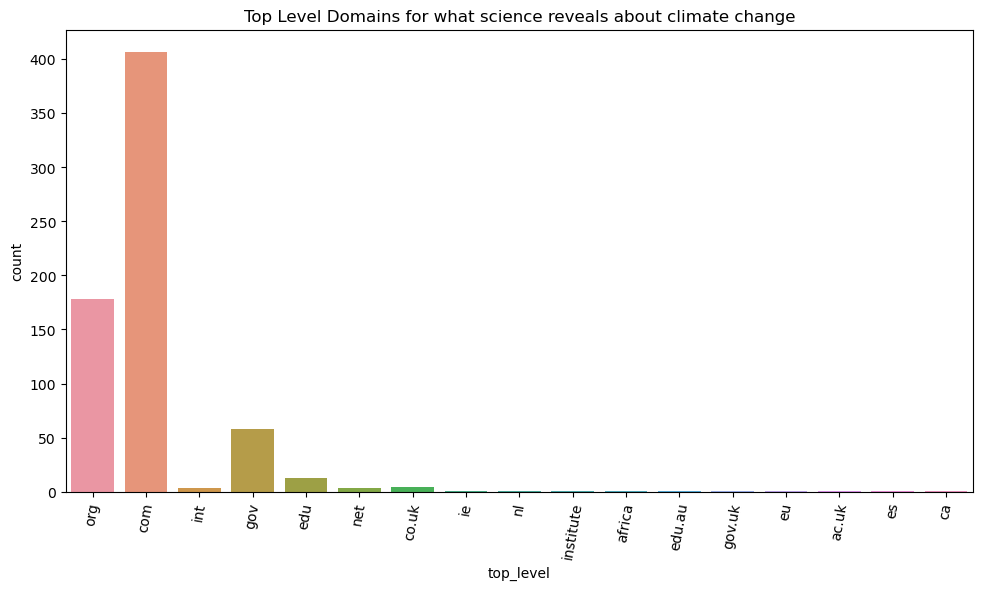

response
200    396
403    138
500    100
404     38
410      2
401      2
406      1
503      1
Name: count, dtype: int64

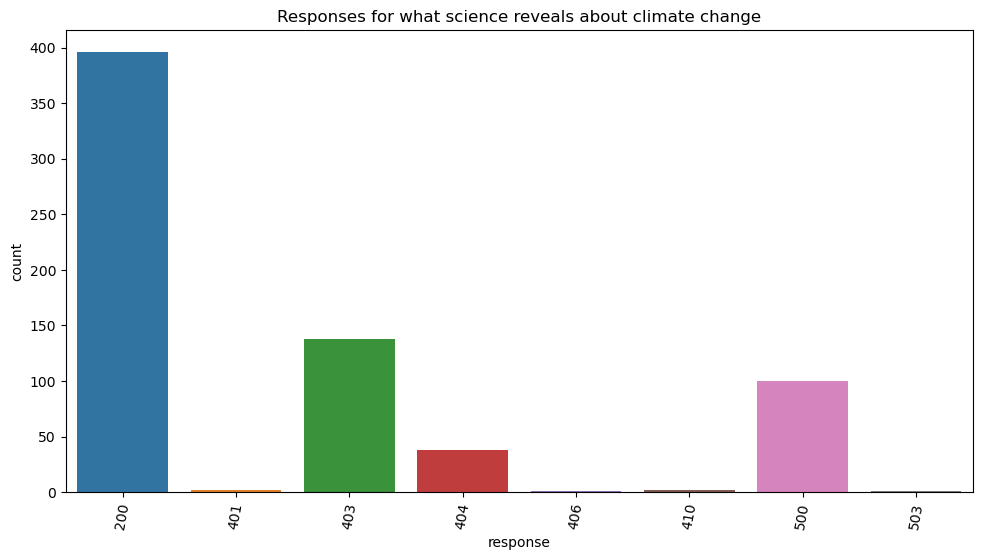

In [92]:
build_report('what-science-reveals-about-climate-change-playlist')

'religion-for-non-believers-playlist'

,video,subdomain,domain,top_level,response
0,are-humans-more-valuable-than-animals,www,amazon,com,500
1,are-humans-more-valuable-than-animals,www,c-span,org,403
2,are-humans-more-valuable-than-animals,www,amazon,com,500
3,are-humans-more-valuable-than-animals,www,amazon,com,500
4,are-humans-more-valuable-than-animals,www,amazon,com,500


,video,subdomain,domain,top_level,response
count,605,536,603,603,605
unique,22,28,138,11,9
top,are-people-born-good,www,amazon,com,200
freq,56,478,106,411,335


subdomain
www              478
books             15
www.iep            4
founders           4
plato              3
curious.astro      3
en                 3
www1               3
www.hsph           2
news               2
www.global         2
Name: count, dtype: int64

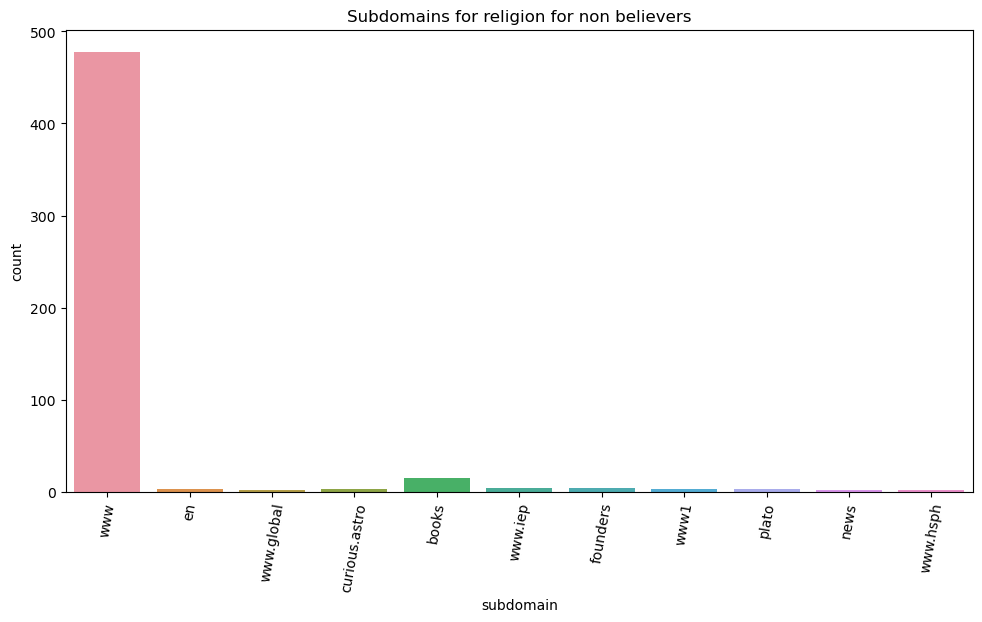

domain
amazon             106
prageru             69
biblegateway        30
peterkreeft         29
youtube             25
nationalreview      16
google              15
reasonablefaith     14
wsj                 13
discovery           13
kofc                12
heritage            11
dennisprager        11
britannica          10
archives             9
townhall             8
loc                  7
theatlantic          6
Name: count, dtype: int64

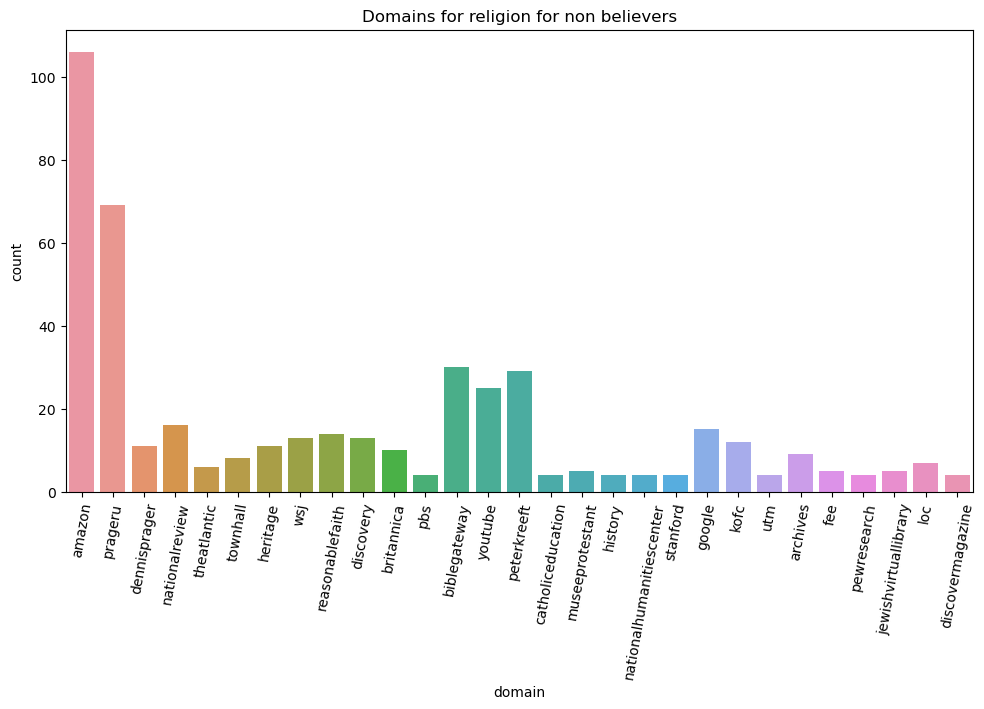

top_level
com       411
org       130
edu        28
gov        24
de          2
co.uk       2
va          2
org.uk      1
net         1
ac.uk       1
gov.uk      1
Name: count, dtype: int64

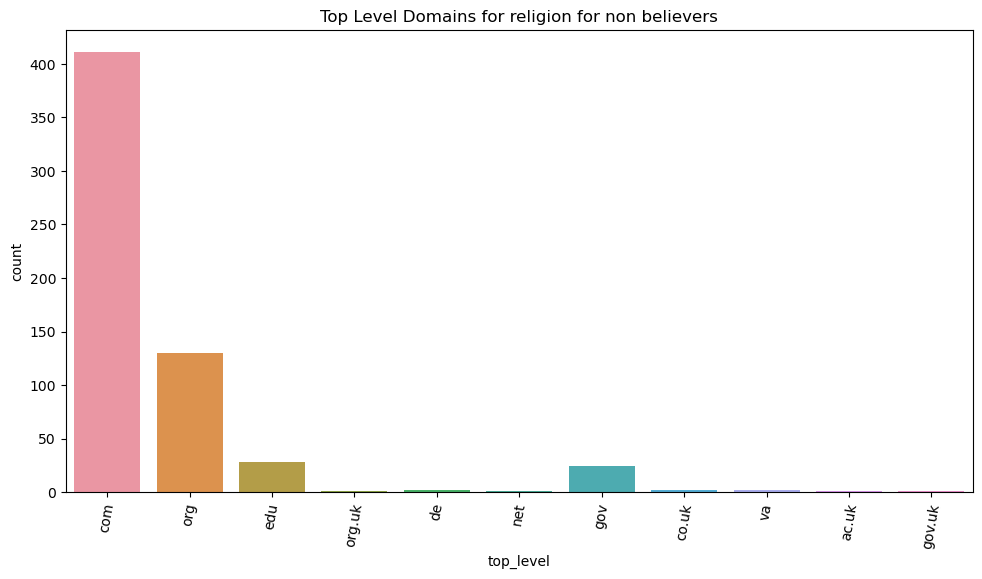

response
200    335
500    105
404     67
403     62
406     29
420      3
503      2
401      1
410      1
Name: count, dtype: int64

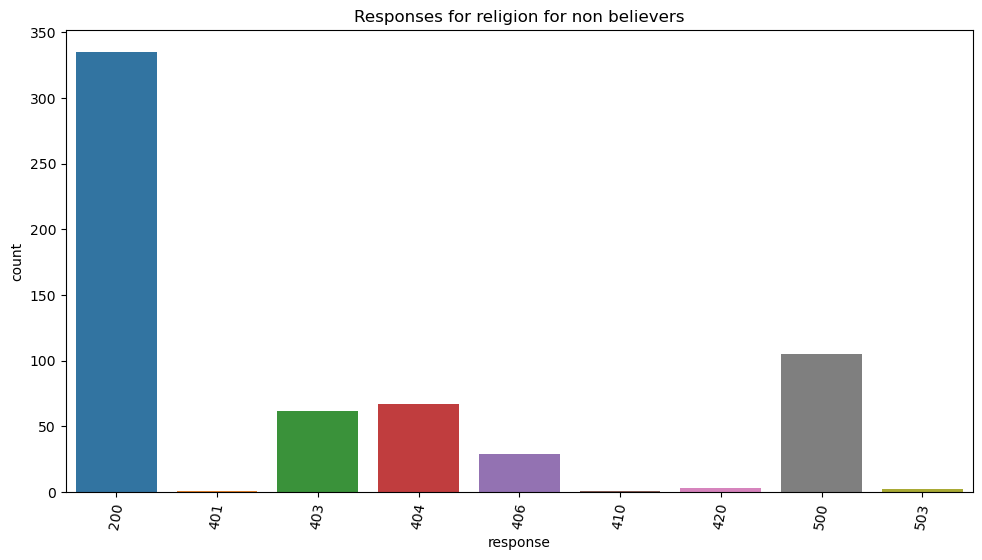

In [95]:
build_report(directory='religion-for-non-believers-playlist')

'guarding-our-freedoms-playlist'

,video,subdomain,domain,top_level,response
0,defining-liberty,constitution,congress,gov,403
1,defining-liberty,constitution,congress,gov,403
2,defining-liberty,constitution,congress,gov,403
3,defining-liberty,NaN,constitutioncenter,org,403
4,defining-liberty,NaN,constitutioncenter,org,403


,video,subdomain,domain,top_level,response
count,191,149,190,190,191
unique,9,19,73,6,5
top,they-say-scandinavia-but-they-mean-venezuela,www,congress,com,200
freq,25,107,13,83,122


subdomain
www             107
constitution     12
www.law           5
shop              4
avalon.law        4
news              3
www.press         2
Name: count, dtype: int64

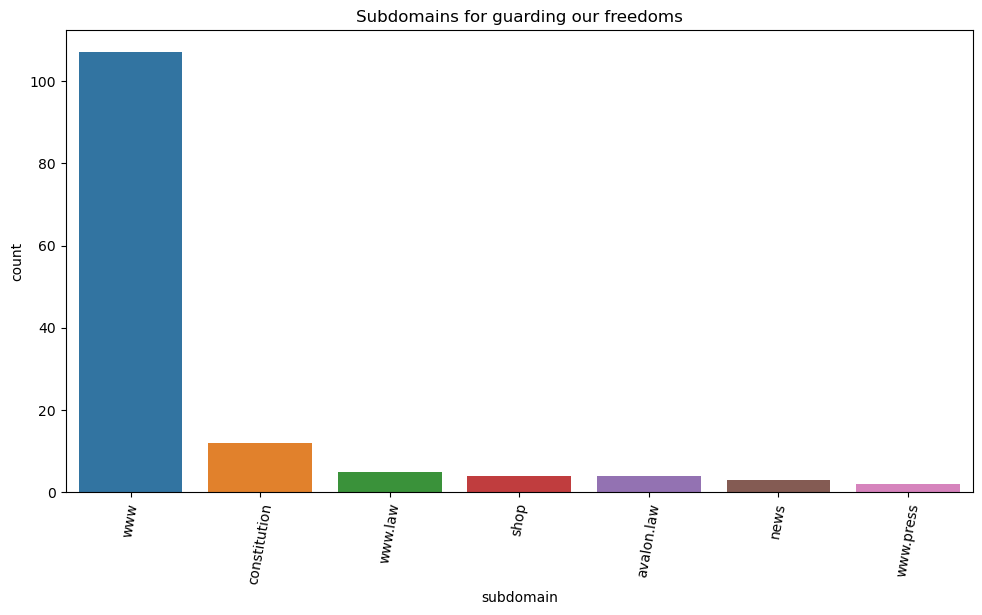

domain
congress              13
heritage              13
constitutioncenter    11
amazon                11
archives               9
nationalreview         8
prageru                7
fee                    7
Name: count, dtype: int64

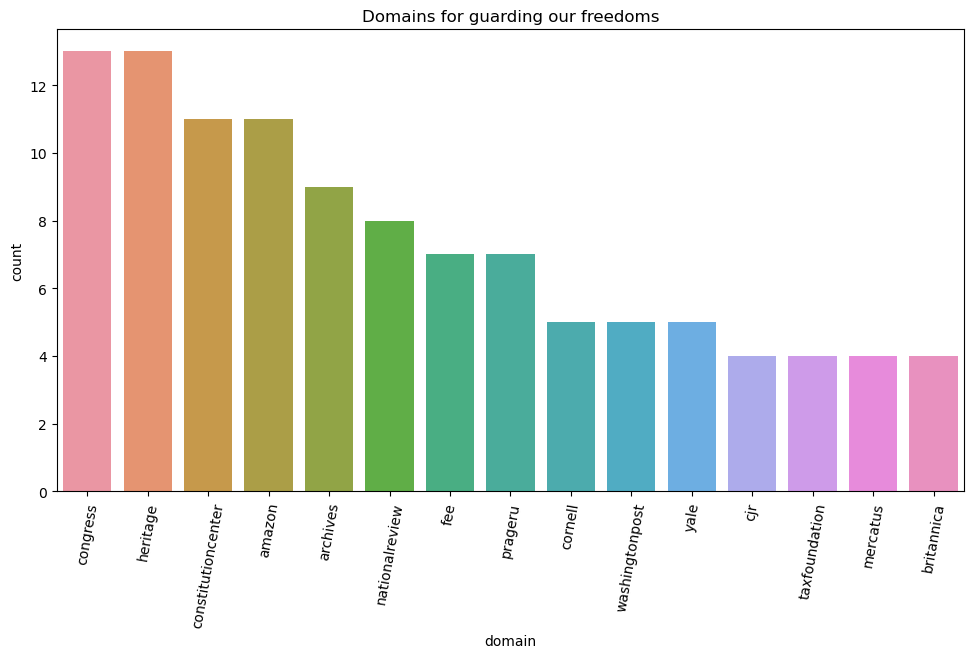

top_level
com       83
org       55
gov       31
edu       19
co.uk      1
edu.au     1
Name: count, dtype: int64

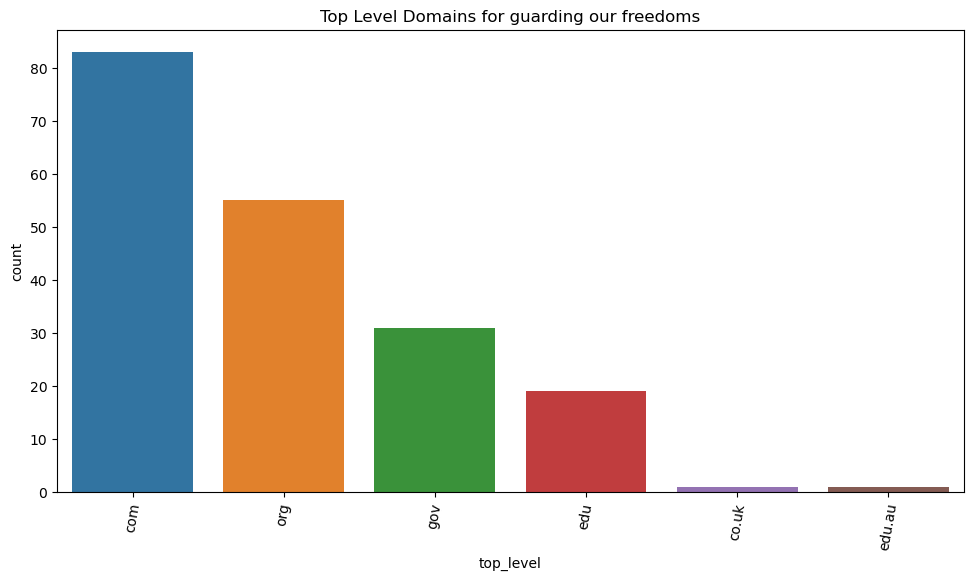

response
200    122
403     47
500     11
404      9
401      2
Name: count, dtype: int64

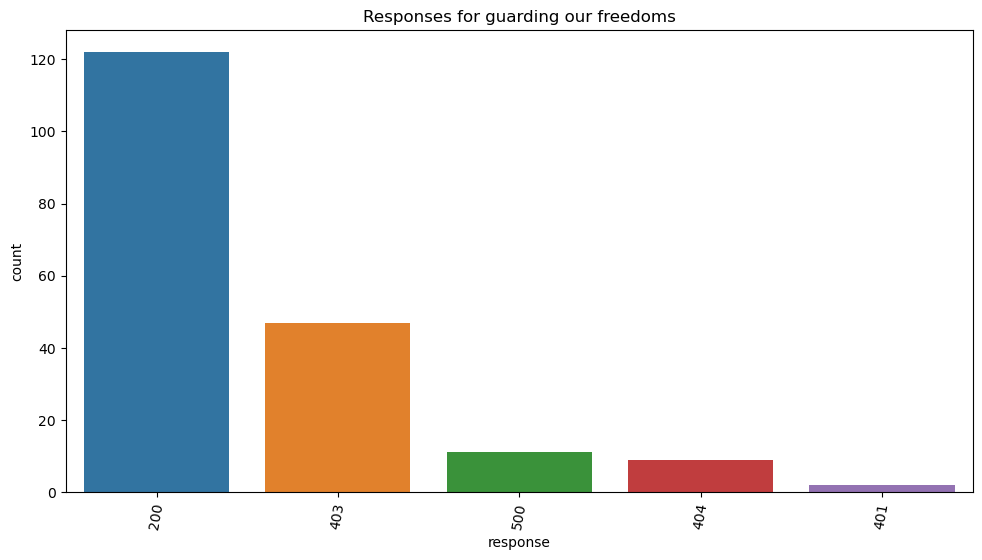

In [100]:
build_report(directory='guarding-our-freedoms-playlist')

'does-free-speech-offend-you-playlist'

,video,subdomain,domain,top_level,response
0,big-tech-is-big-brother,www,history,com,200
1,big-tech-is-big-brother,NaN,thefederalist,com,403
2,big-tech-is-big-brother,www,prageru,com,200
3,big-tech-is-big-brother,NaN,thehill,com,403
4,big-tech-is-big-brother,www,dailywire,com,404


,video,subdomain,domain,top_level,response
count,260,218,260,260,260
unique,13,10,78,8,5
top,control-the-words-control-the-culture,www,nationalreview,com,200
freq,31,206,29,216,186


subdomain
www        206
www.law      3
insider      2
Name: count, dtype: int64

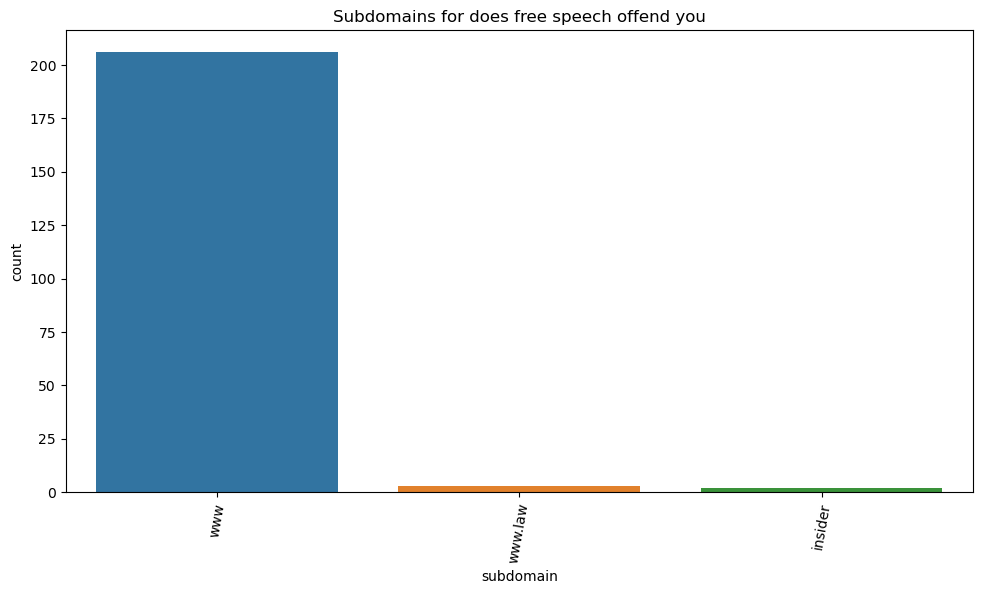

domain
nationalreview    29
youtube           16
prageru           15
heritage          14
amazon            11
thefederalist     10
wsj               10
theatlantic        9
reason             8
latimes            7
foxnews            7
thedailybeast      7
washingtonpost     6
nytimes            6
Name: count, dtype: int64

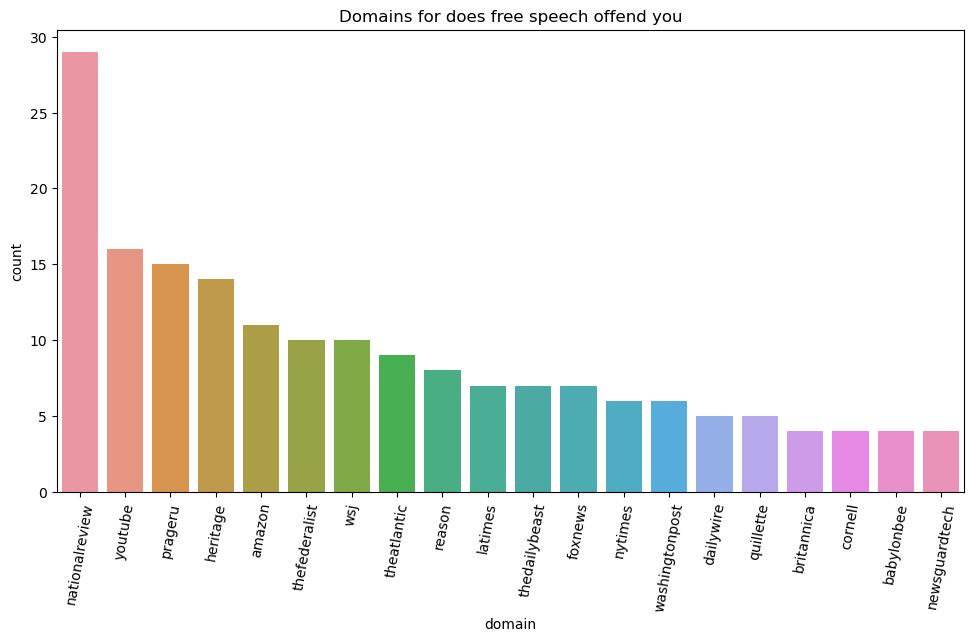

top_level
com      216
org       29
gov        5
edu        5
co.uk      2
ru         1
be         1
co.nz      1
Name: count, dtype: int64

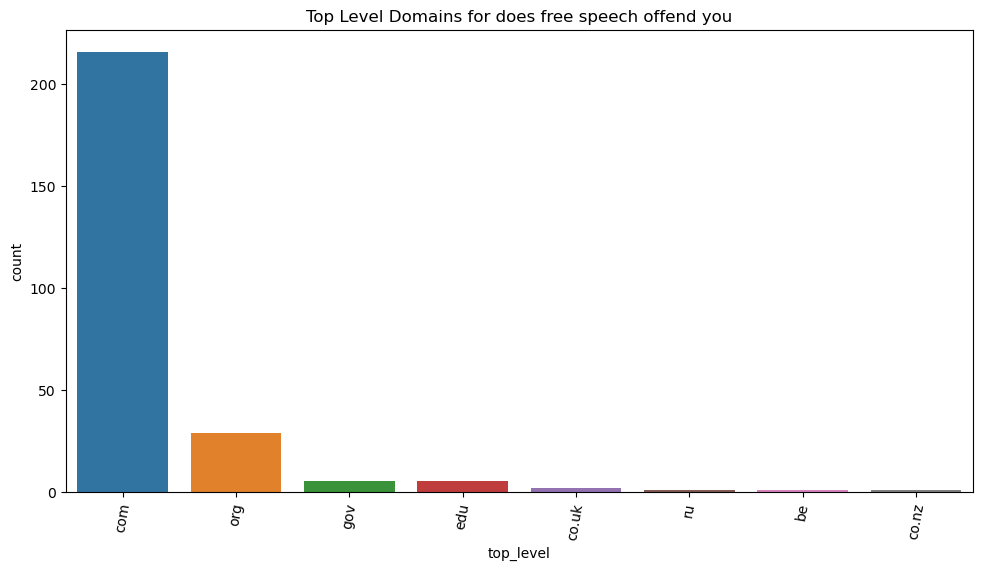

response
200    186
403     52
500     11
404     10
522      1
Name: count, dtype: int64

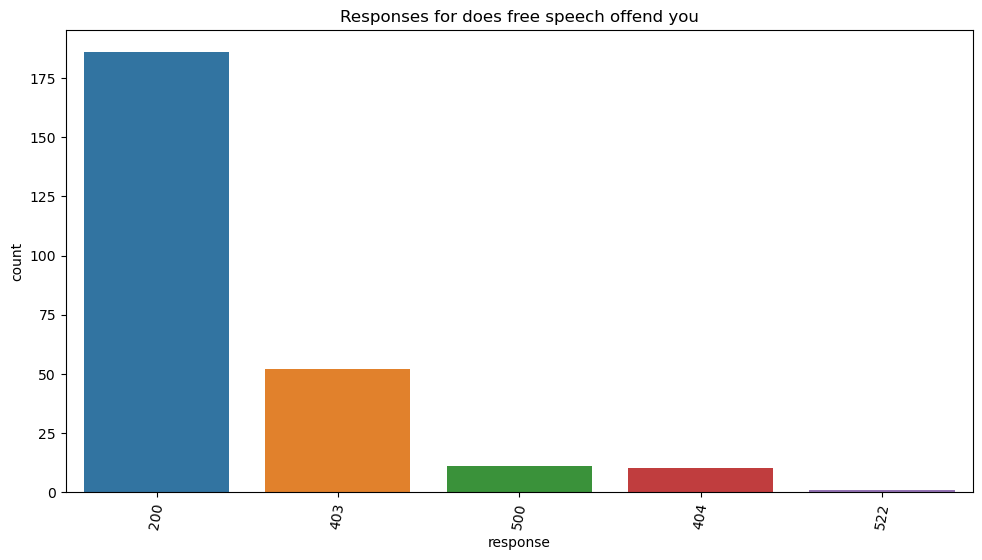

In [112]:
build_report('does-free-speech-offend-you-playlist')